# Logistic Regression with Feature Selection

# Step 1: Import Libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency, f_oneway

# Step 2: Load the Data

In [35]:
df = pd.read_csv('HR_Analytics.csv')

# Step 3: Data Cleaning

In [36]:
df = df.dropna()  # Remove missing values
df = df.select_dtypes(include=['number', 'object'])  # Keep numeric & categorical columns

Convert categorical variables to category dtype

In [37]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

Define features & target

In [38]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Class Imbalance Visualization

<ipython-input-39-4d110ffa9dc8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


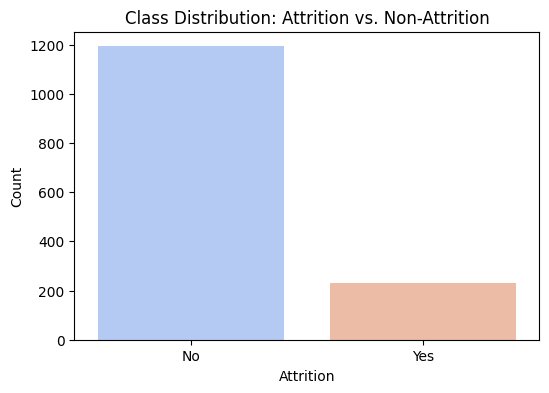

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution: Attrition vs. Non-Attrition")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.show()

# Step 4: Define Target Variable

Ensure 'Attrition' is properly converted to binary values

In [40]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
print(df['Attrition'].unique())  # Should print [0, 1]
df['Attrition'].fillna(0, inplace=True)
df['Attrition'] = df['Attrition'].astype(int)

[1, 0]
Categories (2, int64): [0, 1]


<ipython-input-40-df33ee084d7e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Attrition'].fillna(0, inplace=True)


In [41]:
target = 'Attrition'
df[target] = df[target].astype(int)  # Convert to binary (0,1)

# Step 5: Chi-Square Test for Categorical Variables

In [42]:
selected_categorical = []
for col in df.select_dtypes(include=['category']).columns:
    contingency_table = pd.crosstab(df[col], df[target])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.05:  # Select variables significantly related to Attrition
        selected_categorical.append(col)

In [43]:
# Create an empty list to store results
chi_square_results = []

# Perform the chi-square test for categorical variables
for col in df.select_dtypes(include=['category']).columns:
    contingency_table = pd.crosstab(df[col], df[target])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Append results to the list
    chi_square_results.append({
        'Variable': col,
        'p-value': round(p, 4),
        'Selected': 'Yes' if p < 0.05 else 'No'
    })

# Convert the list to a DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

# Display the table
print(chi_square_results_df)

          Variable  p-value Selected
0            EmpID   0.4133       No
1         AgeGroup   0.0000      Yes
2   BusinessTravel   0.0000      Yes
3       Department   0.0032      Yes
4   EducationField   0.0021      Yes
5           Gender   0.2723       No
6          JobRole   0.0000      Yes
7    MaritalStatus   0.0000      Yes
8       SalarySlab   0.0000      Yes
9           Over18   1.0000       No
10        OverTime   0.0000      Yes


# Step 6: ANOVA Test for Numerical Variables

In [44]:
selected_numerical = []
for col in df.select_dtypes(include=['number']).columns:
    if col != target:
        groups = [df[df[target] == i][col] for i in df[target].unique()]
        f_stat, p = f_oneway(*groups)
        if p < 0.05:  # Select significant variables
            selected_numerical.append(col)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
# Create an empty list to store results
anova_results = []

# Perform ANOVA test for numerical variables
for col in df.select_dtypes(include=['number']).columns:
    if col != target:
        groups = [df[df[target] == i][col] for i in df[target].unique()]
        f_stat, p = f_oneway(*groups)

        # Append results to the list
        anova_results.append({
            'Variable': col,
            'F-statistic': round(f_stat, 4),
            'p-value': round(p, 4),
            'Selected': 'Yes' if p < 0.05 else 'No'
        })

# Convert the list to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Display the table
print(anova_results_df)

                    Variable  F-statistic  p-value Selected
0                        Age      34.3453   0.0000      Yes
1                  DailyRate       4.3949   0.0362      Yes
2           DistanceFromHome       8.7407   0.0032      Yes
3                  Education       0.9243   0.3365       No
4              EmployeeCount          NaN      NaN       No
5             EmployeeNumber       0.3560   0.5509       No
6    EnvironmentSatisfaction      13.8815   0.0002      Yes
7                 HourlyRate       0.1107   0.7394       No
8             JobInvolvement      23.0139   0.0000      Yes
9                   JobLevel      42.8288   0.0000      Yes
10           JobSatisfaction      14.9571   0.0001      Yes
11             MonthlyIncome      38.4880   0.0000      Yes
12               MonthlyRate       0.1903   0.6627       No
13        NumCompaniesWorked       2.5843   0.1082       No
14         PercentSalaryHike       0.4336   0.5103       No
15         PerformanceRating       0.022

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


# Step 7: Keep Only Selected Variables

In [46]:
selected_features = selected_categorical + selected_numerical
df_selected = df[selected_features + [target]]

In [47]:
# Create a DataFrame to display selected variables
selected_features_table = pd.DataFrame({"Selected Variables": selected_features + [target]})

# Display the table
import IPython.display as display
display.display(selected_features_table)

,Selected Variables
0,AgeGroup
1,BusinessTravel
2,Department
3,EducationField
4,JobRole
5,MaritalStatus
6,SalarySlab
7,OverTime
8,Age
9,DailyRate


Convert categorical variables into dummy variables

In [48]:
df_selected = pd.get_dummies(df_selected, columns=selected_categorical, drop_first=True)

Identify categorical columns

In [49]:
categorical_cols = df.select_dtypes(include=['object']).columns

Convert categorical columns

In [50]:
for col in categorical_cols:
    if df[col].nunique() == 2:
        # Use Label Encoding for binary categories
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        # Use One-Hot Encoding for multi-class categories
        df = pd.get_dummies(df, columns=[col], drop_first=True)

Categorical varibales encoding

In [51]:
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

Plot the correlation heatmap

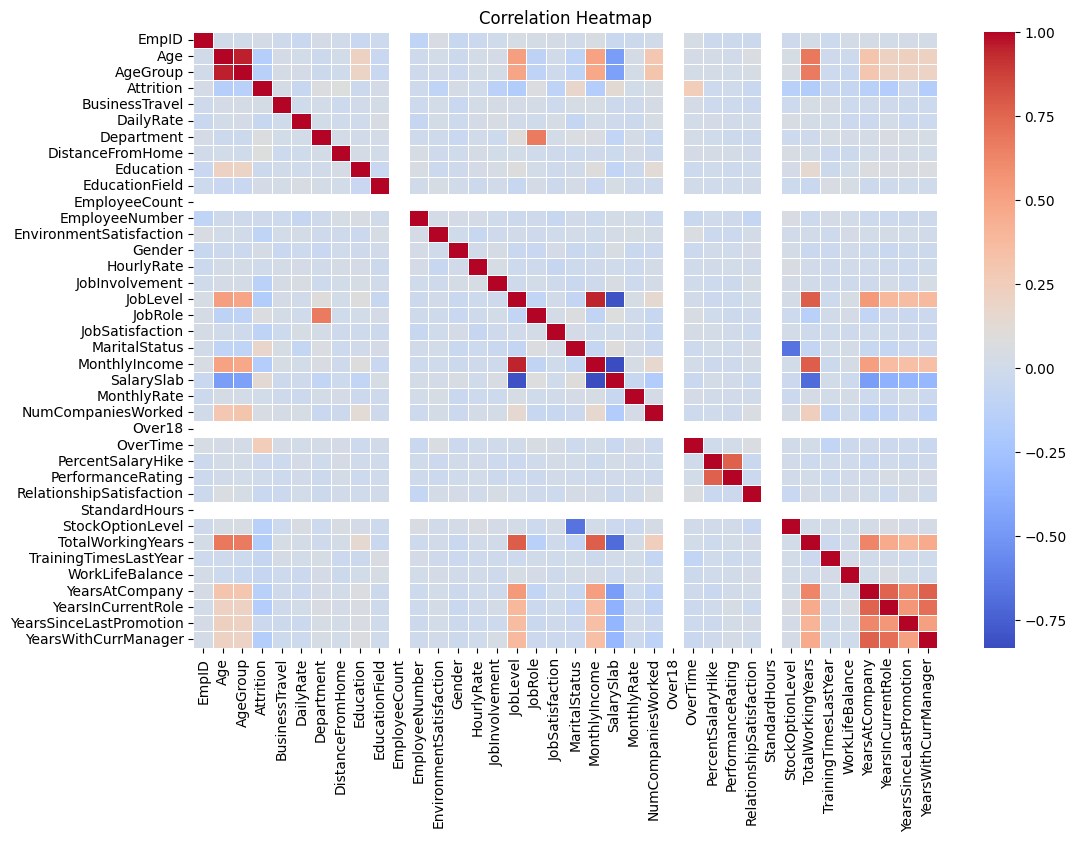

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Step 8: Remove Highly Correlated Features (Multicollinearity)

In [53]:
corr_matrix = df_selected.corr()
high_corr_vars = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:  # Correlation threshold
            colname = corr_matrix.columns[i]
            high_corr_vars.add(colname)

df_selected = df_selected.drop(columns=high_corr_vars)

In [54]:
# Create an empty list to store highly correlated variable pairs
high_corr_results = []

# Compute correlation matrix
corr_matrix = df_selected.corr()
high_corr_vars = set()

# Identify highly correlated variables
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:  # Correlation threshold
            colname = corr_matrix.columns[i]
            high_corr_vars.add(colname)

            # Append results to the list
            high_corr_results.append({
                'Variable 1': corr_matrix.columns[j],
                'Variable 2': colname,
                'Correlation Coefficient': round(corr_matrix.iloc[i, j], 4)
            })

# Convert the list to a DataFrame
high_corr_df = pd.DataFrame(high_corr_results)

# Display the table
print(high_corr_df)

# Drop highly correlated variables
df_selected = df_selected.drop(columns=high_corr_vars)

Empty DataFrame
Columns: []
Index: []


In [55]:
final_selected_variables = selected_features + [target]
final_variables_df = pd.DataFrame({'Final Selected Variables': final_selected_variables})

# Display the table
import IPython.display as display
display.display(final_variables_df)

,Final Selected Variables
0,AgeGroup
1,BusinessTravel
2,Department
3,EducationField
4,JobRole
5,MaritalStatus
6,SalarySlab
7,OverTime
8,Age
9,DailyRate


# Step 9: Train-Test Split

In [56]:
X = df_selected.drop(columns=[target])  # Features
y = df_selected[target]

Train-test split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply SMOTE for class balance

In [58]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Standardize Features

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)  # EDITED: Use resampled data
X_test_scaled = scaler.transform(X_test)

# Step 10: Logistic Regression Model

In [60]:
logit_model = LogisticRegression()
logit_model.fit(X_train_scaled, y_train_sm)

LogisticRegression()

# Step 11: Model Evaluation

In [61]:
y_pred = logit_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8807017543859649
Confusion Matrix:
 [[228   9]
 [ 25  23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       237
           1       0.72      0.48      0.57        48

    accuracy                           0.88       285
   macro avg       0.81      0.72      0.75       285
weighted avg       0.87      0.88      0.87       285



# Step 12: ROC Curve

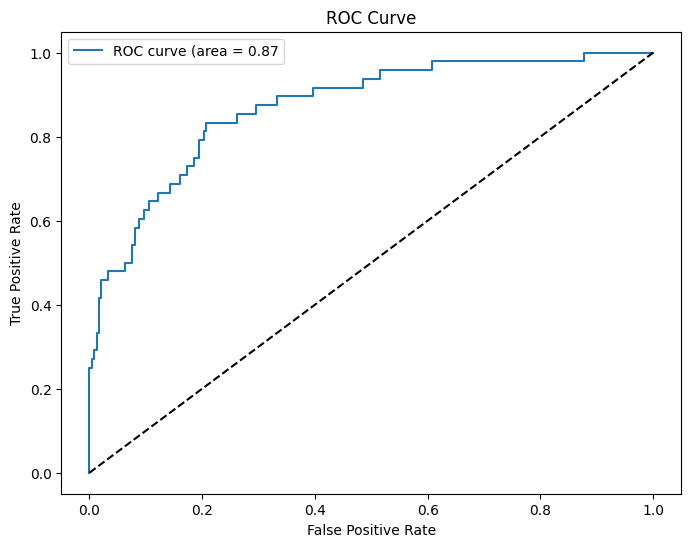

In [62]:
y_pred_prob = logit_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()